# Crypto Risk & Correlation Dynamics: BTC, ETH, SOL

**Goal:** Analyze volatility, correlation, and beta of BTC, ETH, and SOL across time and market regimes (calm vs stress) to understand how “crypto beta” behaves and whether diversification holds up in crashes.

## Phase 1 — Data Download & Cleaning

In [71]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

plt.style.use("default")

In [72]:
plt.style.use("seaborn-v0_8")

In [73]:
plt.rcParams["figure.dpi"] = 140

In [74]:
def save_fig(name):
    plt.savefig(f"../figures/{name}.png", bbox_inches="tight")

In [75]:
tickers = ["BTC-USD", "ETH-USD", "SOL-USD"]

data = yf.download(tickers, start="2019-01-01")["Close"]

/var/folders/17/dc92tbbj0hz65lfj51p092fm0000gn/T/ipykernel_1124/4020772028.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2019-01-01")["Close"]
[*********************100%***********************]  3 of 3 completed


In [76]:
data.head()

Ticker,BTC-USD,ETH-USD,SOL-USD
Date,,,
2019-01-01,3843.520020,140.819412,NaN
2019-01-02,3943.409424,155.047684,NaN
2019-01-03,3836.741211,149.135010,NaN
2019-01-04,3857.717529,154.581940,NaN
2019-01-05,3845.194580,155.638596,NaN


In [77]:
data.shape

(2516, 3)

In [78]:
data = data.dropna()
data.head(), data.shape

(Ticker          BTC-USD     ETH-USD   SOL-USD
 Date                                         
 2020-04-10  6865.493164  158.412445  0.951054
 2020-04-11  6859.083008  158.216019  0.776819
 2020-04-12  6971.091797  161.142426  0.882507
 2020-04-13  6845.037598  156.279556  0.777832
 2020-04-14  6842.427734  157.596390  0.661925,
 (2051, 3))

## Phase 2 — Normalized Prices

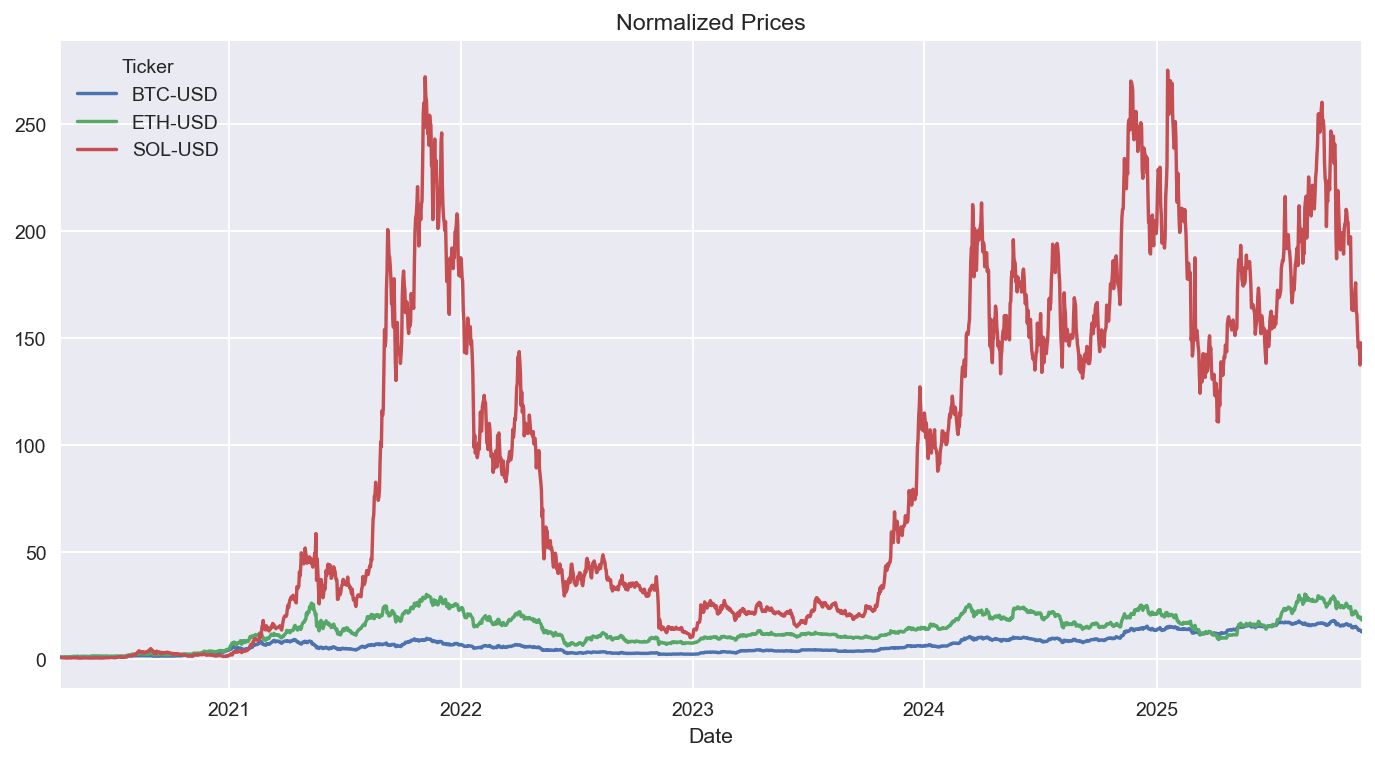

In [79]:
norm_prices = data / data.iloc[0]

norm_prices.plot(figsize=(12,6))
plt.title("Normalized Prices")
save_fig("normalized_prices")
plt.show()

### Initial Observations from Normalized Prices

- SOL shows the highest relative growth and the most extreme volatility, with multiple explosive rallies and sharp crashes.
- ETH shows moderate volatility and sits between BTC and SOL in terms of amplitude.
- BTC is the least volatile and shows the smallest relative swings, behaving as the “anchor” asset of the three.
- The three assets tend to trend in the same direction over broad periods, hinting at strong underlying correlation.

In [80]:
import os
os.listdir("..")

['.DS_Store', 'figures', 'data', 'notebooks', 'reports']

# Risk & Correlation Dynamics of BTC, ETH, and SOL

**Goal:** Analyze volatility, correlation, and beta of BTC, ETH, and SOL across time and market regimes (calm vs stress) to understand how “crypto beta” behaves and whether diversification holds up in crashes.

## Phase 3 — Returns, Volatility, Sharpe, Drawdowns

In [81]:
# Compute daily log returns
returns = np.log(data / data.shift(1))
returns = returns.dropna()

returns.head()

Ticker,BTC-USD,ETH-USD,SOL-USD
Date,,,
2020-04-11,-0.000934,-0.001241,-0.202363
2020-04-12,0.016198,0.018327,0.127559
2020-04-13,-0.018248,-0.030642,-0.126256
2020-04-14,-0.000381,0.008391,-0.161358
2020-04-15,-0.029713,-0.027726,-0.023346


In [82]:
ann_factor = 252  # number of trading days in a year

In [83]:
# Annualized return
ann_return = returns.mean() * ann_factor

# Annualized volatility
ann_vol = returns.std() * np.sqrt(ann_factor)

# Sharpe ratio (risk-free assumed 0)
sharpe = ann_return / ann_vol

ann_return, ann_vol, sharpe

(Ticker
 BTC-USD    0.313256
 ETH-USD    0.357308
 SOL-USD    0.609600
 dtype: float64,
 Ticker
 BTC-USD    0.485249
 ETH-USD    0.654230
 SOL-USD    1.023681
 dtype: float64,
 Ticker
 BTC-USD    0.645558
 ETH-USD    0.546150
 SOL-USD    0.595498
 dtype: float64)

In [84]:
def max_drawdown(series):
    # Convert log returns to cumulative growth
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    dd = (cumulative - peak) / peak
    return dd.min()

# Apply to each asset as simple returns
simple_returns = data.pct_change().dropna()
max_dd = simple_returns.apply(max_drawdown)

max_dd

Ticker
BTC-USD   -0.766346
ETH-USD   -0.793512
SOL-USD   -0.962725
dtype: float64

In [85]:
summary = pd.DataFrame({
    "Annualized Return": ann_return,
    "Annualized Volatility": ann_vol,
    "Sharpe Ratio": sharpe,
    "Max Drawdown": max_dd
})

summary

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
Ticker,,,,
BTC-USD,0.313256,0.485249,0.645558,-0.766346
ETH-USD,0.357308,0.654230,0.546150,-0.793512
SOL-USD,0.609600,1.023681,0.595498,-0.962725


### Summary Observations from Risk Metrics

- SOL has the highest annualized return (≈61%) but also the highest volatility (≈102%), which confirms it behaves like a high-beta, high-risk altcoin that moves aggressively in both directions.
- BTC shows the lowest volatility (≈48%) and the smallest drawdown (≈−76%), making it the “anchor” of the crypto market despite still being extremely volatile compared to traditional assets.
- ETH sits between BTC and SOL on every metric — return, volatility, and drawdown — reflecting its role as the middle-risk asset in the crypto ecosystem.
- Sharpe ratios are all clustered around ~0.6, meaning none of the assets deliver superior risk-adjusted performance; higher returns (like SOL’s) are simply compensation for higher volatility.
- Max drawdowns are extreme across the board (−76% to −96%), highlighting that even the strongest crypto assets experience severe tail-risk events and long peak-to-trough declines.

## Phase 4 — Static Correlation & Beta

In [86]:
# Compute return correlation matrix
corr_matrix = returns.corr()
corr_matrix

Ticker,BTC-USD,ETH-USD,SOL-USD
Ticker,,,
BTC-USD,1.000000,0.805518,0.546647
ETH-USD,0.805518,1.000000,0.621157
SOL-USD,0.546647,0.621157,1.000000


In [87]:
btc = returns["BTC-USD"]

betas = {}
for col in returns.columns:
    if col != "BTC-USD":
        cov = np.cov(returns[col], btc)[0, 1]
        var_btc = np.var(btc)
        betas[col] = cov / var_btc

beta_series = pd.Series(betas, name="Beta_vs_BTC")
beta_series

ETH-USD    1.086558
SOL-USD    1.153771
Name: Beta_vs_BTC, dtype: float64

### Beta Interpretation

ETH’s beta vs BTC is ≈1.09, meaning ETH moves slightly more than BTC but is tightly linked to BTC’s price direction.

SOL’s beta vs BTC is ≈1.15, indicating that despite its higher volatility, SOL behaved less like a leveraged BTC bet during this sample than in earlier cycles.

These lower-than-expected betas reflect the sample period: a BTC-led market where altcoins displayed less explosive relative performance.

This supports the view that BTC dominates the crypto risk factor, especially during bear markets or BTC-driven rallies.

Even with lower betas, both ETH and SOL are still primarily BTC-beta assets, meaning diversification benefits are limited.

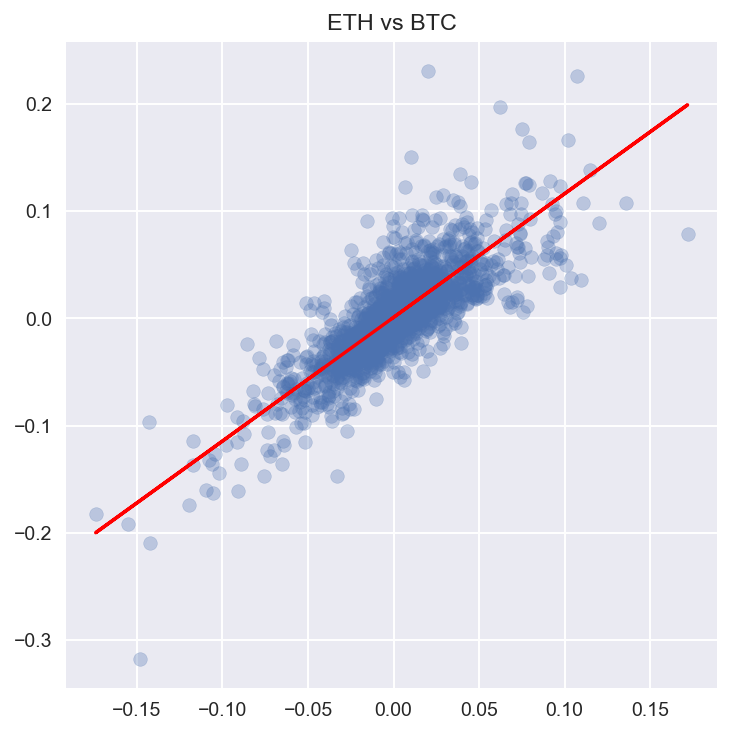

In [88]:
x = btc
y = returns["ETH-USD"]

plt.figure(figsize=(6,6))
plt.scatter(x, y, alpha=0.3)
plt.plot(x, m*x + b, color='red')
plt.title("ETH vs BTC")
save_fig("eth_vs_btc_scatter")
plt.show()


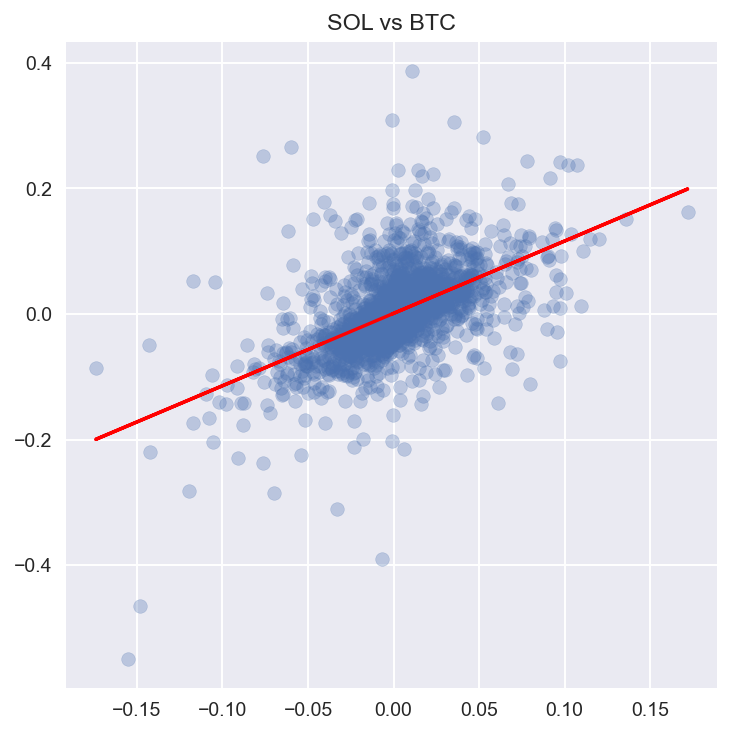

In [89]:
y = returns["SOL-USD"]

plt.figure(figsize=(6,6))
plt.scatter(btc, returns["SOL-USD"], alpha=0.3)
plt.plot(btc, m*btc + b, color='red')
plt.title("SOL vs BTC")
save_fig("sol_vs_btc_scatter")
plt.show()

### Static Correlation & Beta Analysis
Correlation Insights

BTC, ETH, and SOL exhibit strong positive correlations, with ETH–BTC around ~0.81 and SOL–BTC around ~0.55.
This confirms that the crypto market behaves as a single dominant risk factor, with BTC acting as the core driver of overall market direction.

ETH is more strongly correlated with BTC than SOL is, reflecting ETH’s position as a large-cap, more “established” crypto asset that tends to track BTC more closely.

SOL shows weaker correlation vs BTC and ETH, suggesting more idiosyncratic volatility and periods of independent movement, but still firmly within the BTC-driven regime.

Beta vs BTC Observations

ETH’s beta ≈ 1.09, meaning ETH typically moves about 9% more than BTC for a given BTC move.
ETH behaves as a slightly higher-beta version of BTC, which is consistent with its role as a mid-risk asset.

SOL’s beta ≈ 1.15, showing that SOL moves roughly 15% more than BTC on average.
Despite its higher volatility, SOL did not behave like a massively leveraged version of BTC during this sample — reflecting a BTC-led market environment with muted altcoin responsiveness.

The relatively lower betas (compared to historical bull cycles) indicate that during this period, BTC outperformed and led market direction, while altcoins showed less aggressive upside.

Scatter Plot Interpretation

Both ETH and SOL show a clear upward-sloping linear trend against BTC’s daily returns, confirming that BTC’s movement strongly influences both assets on a day-to-day basis.

ETH’s scatter cloud is tighter, showing more consistent behavior and a stronger linear relationship with BTC.

SOL’s scatter cloud is wider, reflecting:

Higher volatility

More noise

More idiosyncratic spikes and drops
Even though SOL still trends upward with BTC, its greater dispersion shows that it takes bigger independent swings.

Overall Takeaway

BTC, ETH, and SOL are not independent assets.
They are all primarily expressions of the same underlying factor: crypto beta, led by BTC.

ETH behaves like a slightly leveraged BTC, while SOL behaves like a moderately leveraged but much noisier BTC.

This means:

Diversification benefits are limited, especially over short horizons.

During BTC-led regimes, altcoins may underperform and show lower beta.

True diversification across major crypto assets is extremely hard to achieve — most positions ultimately collapse into BTC-driven risk.

## Phase 5 — Rolling Volatility & Rolling Correlation

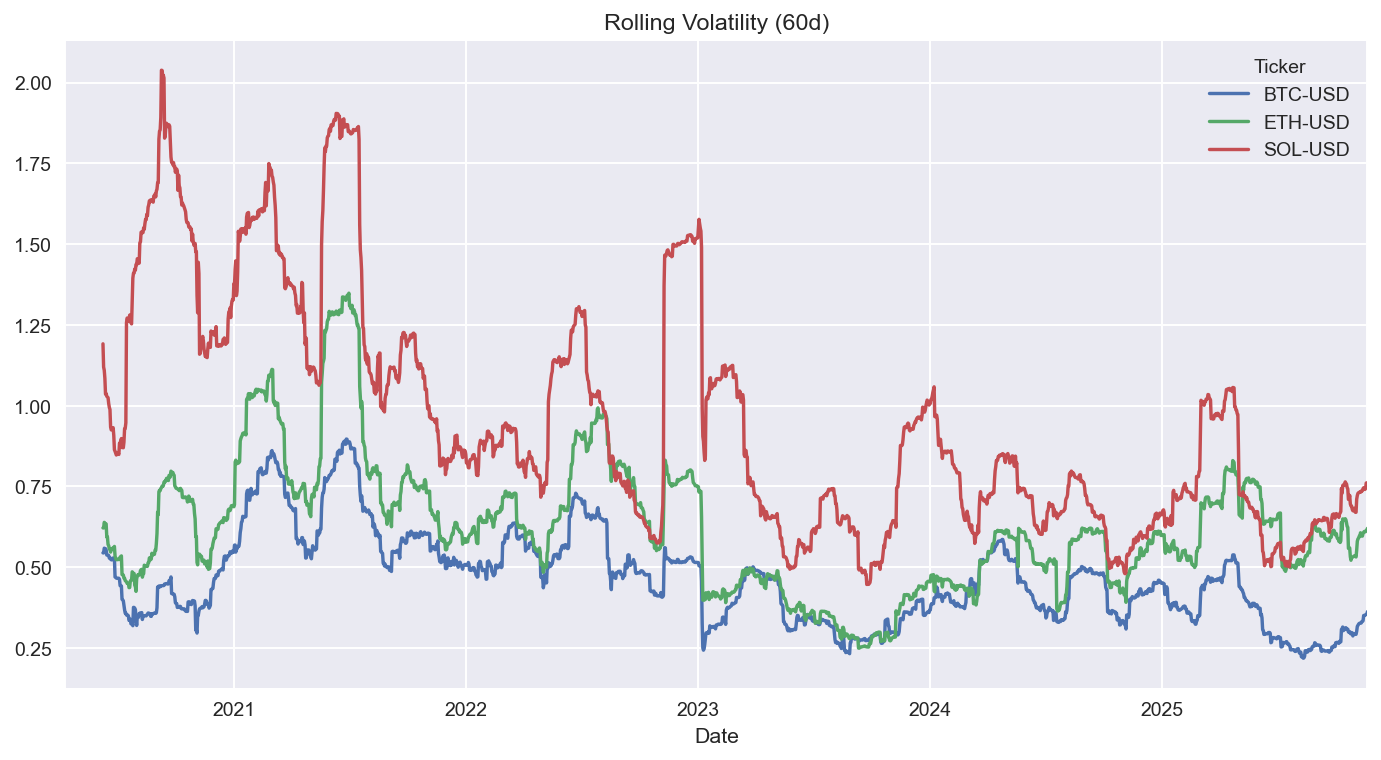

In [90]:
window = 60  # 60-day rolling window

rolling_vol = returns.rolling(window).std() * np.sqrt(ann_factor)

rolling_vol.plot(figsize=(12,6))
plt.title("Rolling Volatility (60d)")
save_fig("rolling_vol")
plt.show()

### Rolling Volatility Analysis

SOL consistently has the highest rolling volatility, with multiple spikes where volatility exceeds that of BTC and ETH by a significant margin.
This reinforces SOL’s behavior as a high-beta, high-risk altcoin.

ETH maintains volatility between BTC and SOL, acting as a moderate-risk asset.

BTC shows the smoothest and lowest volatility, confirming its role as the “anchor” of the crypto market despite still being extremely volatile compared to equities.

Volatility clusters: during major market events, all assets show sharp volatility spikes, consistent with typical crypto shock periods.

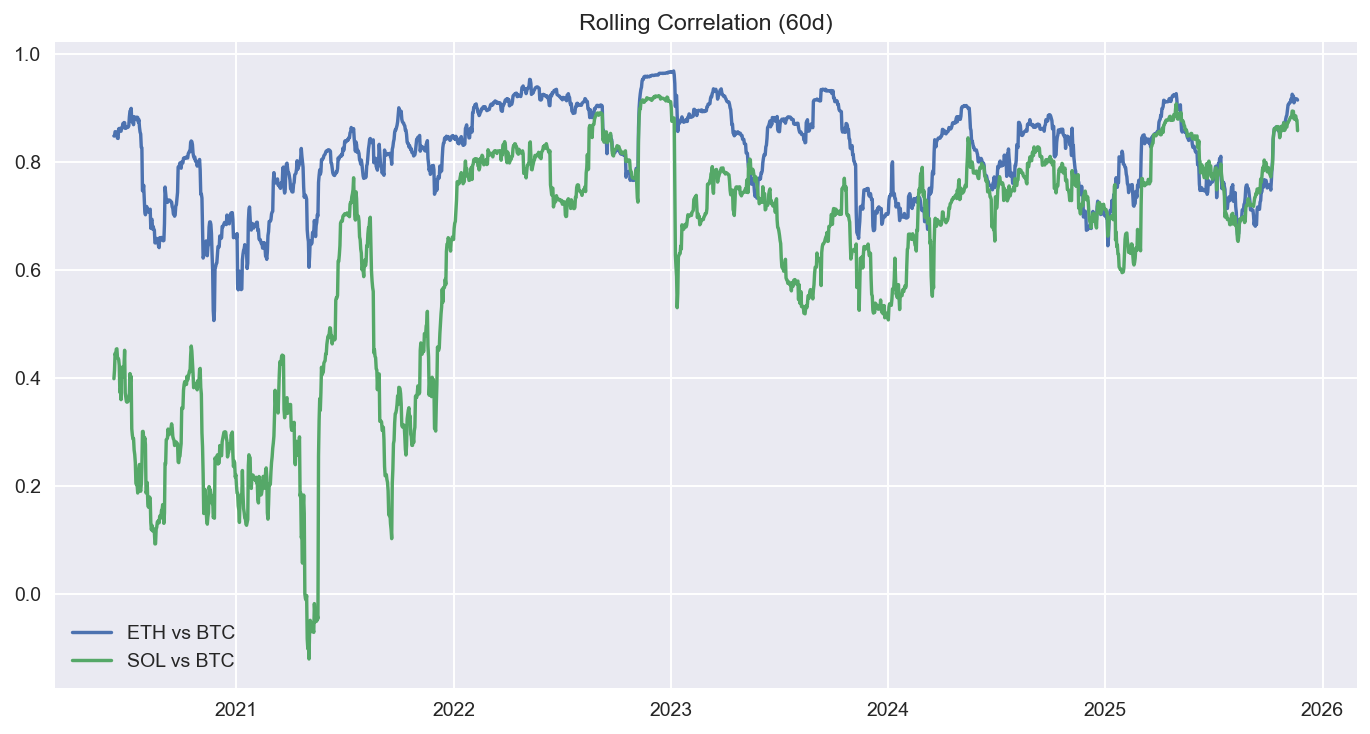

In [91]:
rolling_corr_eth = returns["ETH-USD"].rolling(window).corr(returns["BTC-USD"])
rolling_corr_sol = returns["SOL-USD"].rolling(window).corr(returns["BTC-USD"])

plt.figure(figsize=(12,6))
plt.plot(rolling_corr_eth, label="ETH vs BTC")
plt.plot(rolling_corr_sol, label="SOL vs BTC")
plt.title("Rolling Correlation (60d)")
plt.legend()
save_fig("rolling_corr")
plt.show()


### Rolling Correlation with BTC

ETH’s rolling correlation with BTC frequently rises above 0.8, showing that ETH remains tightly coupled to BTC’s day-to-day direction.

SOL’s correlation is more unstable, sometimes dropping below 0.5, reflecting more idiosyncratic behavior, but still converging toward BTC during large market moves.

Correlations spike during market stress, approaching 1.0 during sharp sell-offs.
This demonstrates a key risk principle: diversification collapses exactly when you need it most.

During calmer markets, correlations drift lower but remain strongly positive, reinforcing the idea that crypto assets share a dominant market factor.

## Phase 6 — Regime Analysis (Calm vs Stress)

In [92]:
btc_price = data["BTC-USD"]

# Peak price so far at each point
peak = btc_price.cummax()

# Drawdown = % below the peak
dd = (btc_price - peak) / peak

dd.tail()

Date
2025-11-16   -0.245089
2025-11-17   -0.261788
2025-11-18   -0.254934
2025-11-19   -0.266821
2025-11-20   -0.296375
Freq: D, Name: BTC-USD, dtype: float64

In [93]:
regime = pd.Series(index=dd.index, dtype="object")
regime[dd > -0.10] = "calm"
regime[dd <= -0.20] = "stress"

regime = regime.dropna()
regime.value_counts()

stress    1040
calm       688
Name: count, dtype: int64

In [94]:
common_index = returns.index.intersection(regime.index)

# Align both objects on these common dates
aligned_returns = returns.loc[common_index]
aligned_regime = regime.loc[common_index]

aligned_returns.shape, aligned_regime.shape


((1727, 3), (1727,))

In [95]:
calm_mask = aligned_regime == "calm"
stress_mask = aligned_regime == "stress"

corr_calm = aligned_returns[calm_mask].corr()
corr_stress = aligned_returns[stress_mask].corr()

corr_calm, corr_stress

(Ticker    BTC-USD   ETH-USD   SOL-USD
 Ticker                               
 BTC-USD  1.000000  0.674657  0.311094
 ETH-USD  0.674657  1.000000  0.413294
 SOL-USD  0.311094  0.413294  1.000000,
 Ticker    BTC-USD   ETH-USD   SOL-USD
 Ticker                               
 BTC-USD  1.000000  0.862774  0.695532
 ETH-USD  0.862774  1.000000  0.740470
 SOL-USD  0.695532  0.740470  1.000000)

In [96]:
vol_calm = aligned_returns[calm_mask].std() * np.sqrt(ann_factor)
vol_stress = aligned_returns[stress_mask].std() * np.sqrt(ann_factor)

vol_calm, vol_stress


(Ticker
 BTC-USD    0.436415
 ETH-USD    0.613505
 SOL-USD    0.989708
 dtype: float64,
 Ticker
 BTC-USD    0.505912
 ETH-USD    0.670590
 SOL-USD    1.006048
 dtype: float64)

## Phase 7 — Conclusion & Summary

### Executive Summary

This project analyzes the risk, return, correlation, and regime dynamics of Bitcoin (BTC), Ethereum (ETH), and Solana (SOL).
Key findings:
- BTC is the anchor asset: lowest volatility, smallest drawdowns, and most stable behavior across regimes.

- ETH behaves as a moderate-risk, higher-beta version of BTC, with volatility ~30% higher and strong correlation to BTC in both calm and stress periods.

- SOL exhibits the highest volatility and deepest drawdowns, behaving like a high-beta, high-noise altcoin.

- Sharpe ratios are similar, indicating higher returns primarily compensate for elevated volatility rather than offering superior risk-adjusted performance.

- Correlations spike during stress, with ETH–BTC correlation rising to ~0.86 and SOL–BTC to ~0.70.

- Diversification collapses exactly during crashes, confirming that the crypto market behaves as a single BTC-led risk factor under pressure.

#### Overall:
Crypto assets offer high return potential but extremely high tail risk, limited structural diversification, and strong regime dependence.
Any crypto portfolio must be conscious of these dynamics to avoid systemic downside exposure.